### Imports

In [45]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import numpy as np

### Loading the Dataset

In [46]:
df=pd.read_csv("mitofish.12S.Sep2021.tsv", sep='\t', header=0)

### Only selecting the family and sequence row

In [47]:
df=df[['Family','Sequence']]

In [48]:
# Adding a column that has the length of the sequence
df['Sequence_length']= df['Sequence'].apply(lambda x: len(x))

### Only selecting the sequences that have length less or equal to 200

In [49]:
df=df.loc[df['Sequence_length'] <= 200]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C53D4B1AC8>]],
      dtype=object)

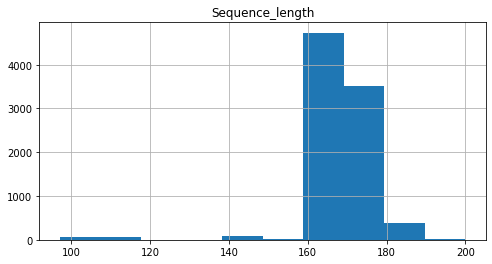

In [51]:
df.hist(column="Sequence_length", figsize=(8,4), bins=10)

### Creating a sliding window of 3 for the sequence

In [52]:
def getKmers(sequence, size=3):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

In [53]:
df['words'] = df.apply(lambda x: getKmers(x['Sequence']), axis=1)

In [54]:
df['sentence']=df['words'].apply(lambda x: ' '.join(x))

In [55]:
corpus=list(df['sentence'])
vectorizer=CountVectorizer()
X=vectorizer.fit_transform(corpus)
features=vectorizer.get_feature_names()

### Creating a one hot encoder for each unique sequence 

In [56]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(features)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [57]:
# Dictionary that stores the uniqe sequence as a key and the one-hot encoder as the value
feature_encoder_mapper = dict(zip(features, onehot_encoded))

### Mapper function that maps the unique sequnece with its respective one-hot encoded value

In [58]:
def dna_mapper(sequence,mapper):
    encoded_dna=[]
    for feature in sequence:
        encoded_dna.append(mapper[feature])
    return encoded_dna

In [61]:
# Creating a zero vector to replace sequence that does not meet the max length
zero_arr=np.zeros((len(features),), dtype=int)

In [62]:
max_seq_length=max(df.Sequence_length)

In [68]:
unique_classes = df['Family'].nunique()
print("The total number of samples are: ", len(df))
print("The total number of unique classes are ", unique_classes)

The total number of samples are:  8890
The total number of unique classes are  444


In [63]:
entire_dataset=[]

for i in range(len(df)):
    my_seq=df['words'].iloc[i]
    encoded_seq=dna_mapper(my_seq,feature_encoder_mapper)
    if len(encoded_seq)<max_seq_length:
        for i in range(len(encoded_seq),max_seq_length):
            encoded_seq.append(zero_arr)
    entire_dataset.append(encoded_seq)

### Train test split

In [83]:
from sklearn.model_selection import train_test_split

X = entire_dataset
y = df['Family']
label_encoder_y = LabelEncoder()
y = label_encoder_y.fit_transform(list(y))
# Choose your test size to split between training and testing sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [84]:
X_train=np.array(X_train)
X_test=np.array(X_test)
y_train=np.array(y_train)
y_test=np.array(y_test)

### Shape of training data
1. 6667 is the total number of training samples
2. 200 is the length of sequence
3. 114 is the total number of unique 3-mers dna sequence

In [85]:
X_train.shape

(6667, 200, 114)

In [90]:
# reshaping the array to 4-dms
X_train=X_train.reshape(X_train.shape[0],200,114,1)
X_test=X_test.reshape(X_test.shape[0],200,114,1)
input_shape=(200,114,1)

In [98]:
## Importing tenserflow and keras 
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

### Building CNN model

In [122]:
num_filters = 8
filter_size = 3
pool_size = 2

model = Sequential([
  Conv2D(num_filters, filter_size, input_shape=input_shape),
  MaxPooling2D(pool_size=pool_size),
  Flatten(),
  Dense(1024, activation='relu'),
  Dropout(0.2),
  Dense(445, activation='softmax'),
])

In [123]:
model.compile(
  'adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'],
)

In [124]:
model.fit(x=X_train, y=y_train, epochs=10, batch_size=32)

Epoch 1/10
6667/6667 [==============================] - 123s 18ms/step - loss: 1.9109 - accuracy: 0.6946
Epoch 2/10
6667/6667 [==============================] - 124s 19ms/step - loss: 0.4247 - accuracy: 0.9207
Epoch 3/10
6667/6667 [==============================] - 124s 19ms/step - loss: 0.1875 - accuracy: 0.9592
Epoch 4/10
6667/6667 [==============================] - 126s 19ms/step - loss: 0.1250 - accuracy: 0.9736
Epoch 5/10
6667/6667 [==============================] - 122s 18ms/step - loss: 0.0764 - accuracy: 0.9829
Epoch 6/10
6667/6667 [==============================] - 124s 19ms/step - loss: 0.0665 - accuracy: 0.9865
Epoch 7/10
6667/6667 [==============================] - 122s 18ms/step - loss: 0.0606 - accuracy: 0.9868
Epoch 8/10
6667/6667 [==============================] - 124s 19ms/step - loss: 0.0598 - accuracy: 0.9900
Epoch 9/10
6667/6667 [==============================] - 126s 19ms/step - loss: 0.0511 - accuracy: 0.9915
Epoch 10/10
6667/6667 [==============================] 

### Checking the accuracy of the model

In [126]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)


Test accuracy: 0.9212775826454163


### Predicting the test dataset

In [127]:
predictions=model.predict(X_test)

### Comparing 5 test result with expected result

In [128]:
print(np.argmax(predictions[:5], axis=1))

[381 227 250 175 175]


In [129]:
print(y_test[:5])

[381 227 250 175 175]
